In [1]:
# Install necessary packages
!pip install datasets gensim tensorflow

import pandas as pd
import numpy as np
import re
from datasets import load_dataset
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import set_random_seed
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import random
my_seed = 42
set_random_seed(my_seed)
random.seed(my_seed)
np.random.seed(my_seed)

import tensorflow as tf  # Only if TF is installed
tf.random.set_seed(my_seed)

import torch  # Only if the backend is 'torch'
torch.manual_seed(my_seed)

# Download punkt tokenizer
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
def process_sentence(sentence):
  # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(sentence))
    # remove all single characters
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    # Remove single characters from the start
    processed_feature = re.sub(r'^[a-zA-Z]\s+', ' ', processed_feature)
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    # Converting to Lowercase
    processed_feature = processed_feature.lower()
    return processed_feature

In [3]:
# Vectorize sentences by averaging word vectors
def vectorize_sentences(sentences, model, vector_size):
    vectors = []
    for sentence in sentences:
        vector = np.mean([model.wv[word] for word in sentence if word in model.wv] or [np.zeros(vector_size)], axis=0)
        vectors.append(vector)
    return np.array(vectors)

In [4]:
def custom_train_and_display_results(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  print("Classification Report:")
  print(classification_report(y_test, predictions))

In [5]:
# Load dataset
dataset = load_dataset("dair-ai/emotion")
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
train_df["processed_text"] = train_df["text"].apply(process_sentence)
test_df["processed_text"] = test_df["text"].apply(process_sentence)

# Tokenize sentences
def tokenize_sentences(sentences):
    tokenized_data = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokenized_data.append([token.lower() for token in tokens])
    return tokenized_data

data = tokenize_sentences(train_df["processed_text"])
test_data = tokenize_sentences(test_df["processed_text"])

print(data)
print(test_data)

[['didnt', 'feel', 'humiliated'], ['can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake'], ['im', 'grabbing', 'minute', 'to', 'post', 'feel', 'greedy', 'wrong'], ['am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'will', 'know', 'that', 'it', 'is', 'still', 'on', 'the', 'property'], ['am', 'feeling', 'grouchy'], ['ive', 'been', 'feeling', 'little', 'burdened', 'lately', 'wasnt', 'sure', 'why', 'that', 'was'], ['ive', 'been', 'taking', 'or', 'milligrams', 'or', 'times', 'recommended', 'amount', 'and', 'ive', 'fallen', 'asleep', 'lot', 'faster', 'but', 'also', 'feel', 'like', 'so', 'funny'], ['feel', 'as', 'confused', 'about', 'life', 'as', 'teenager', 'or', 'as', 'jaded', 'as', 'year', 'old', 'man'], ['have', 'been', 'with', 'petronas', 'for', 'years', 'feel', 'that', 'petronas', 'has', 'performed', 'well', 'and', 'made', 'huge', 'profit'], ['feel', 'romantic'

In [ ]:
train_df.head()

,text,label,processed_text
0,i didnt feel humiliated,0,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,can go from feeling so hopeless to so damned ...
2,im grabbing a minute to post i feel greedy wrong,3,im grabbing minute to post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,am ever feeling nostalgic about the fireplace...
4,i am feeling grouchy,3,am feeling grouchy


In [ ]:
# Combine data for Word2Vec training
combined_data = data + test_data

# Train Word2Vec model on combined data
word2vec_model = Word2Vec(combined_data, vector_size=100, window=5, min_count=5, workers=4)

X_train = vectorize_sentences(data, word2vec_model, 100)
X_test = vectorize_sentences(test_data, word2vec_model, 100)

y_train = train_df["label"]
y_test = test_df["label"]

# Train Logistic Regression model
logreg_model_with_word2vec = LogisticRegression(max_iter=15000, random_state=my_seed)
custom_train_and_display_results(logreg_model_with_word2vec, X_train, y_train, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.47      0.42       581
           1       0.42      0.76      0.54       695
           2       0.00      0.00      0.00       159
           3       0.00      0.00      0.00       275
           4       0.33      0.02      0.03       224
           5       0.00      0.00      0.00        66

    accuracy                           0.40      2000
   macro avg       0.19      0.21      0.17      2000
weighted avg       0.29      0.40      0.31      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
nltk.download("stopwords")
tfidf_vectorizer_with_stopwords = TfidfVectorizer(
        max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
X_train_tfidf_stopwords_removed = tfidf_vectorizer_with_stopwords.fit_transform(train_df["processed_text"].values).toarray()
X_test_tfidf_stopwords_removed = tfidf_vectorizer_with_stopwords.transform(test_df["processed_text"].values).toarray()

tfidf_vectorizer = TfidfVectorizer(
        max_features=2500, min_df=7, max_df=0.8, stop_words=None)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["processed_text"].values).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_df["processed_text"].values).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
logreg_model_tfidf_stopwords_removed = LogisticRegression(max_iter=750, random_state=my_seed)
custom_train_and_display_results(logreg_model_tfidf_stopwords_removed, X_train_tfidf_stopwords_removed, y_train, X_test_tfidf_stopwords_removed, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       581
           1       0.86      0.94      0.90       695
           2       0.78      0.67      0.72       159
           3       0.88      0.83      0.86       275
           4       0.87      0.81      0.84       224
           5       0.89      0.48      0.63        66

    accuracy                           0.87      2000
   macro avg       0.86      0.78      0.81      2000
weighted avg       0.87      0.87      0.87      2000



In [ ]:
logreg_model_tfidf = LogisticRegression(max_iter=750, random_state=my_seed)
custom_train_and_display_results(logreg_model_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       581
           1       0.84      0.96      0.90       695
           2       0.82      0.62      0.71       159
           3       0.92      0.83      0.87       275
           4       0.88      0.80      0.84       224
           5       0.82      0.50      0.62        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.87      0.87      0.87      2000



In [ ]:
nb_model_tfidf_stopwords_remvoed = MultinomialNB()
custom_train_and_display_results(nb_model_tfidf_stopwords_remvoed, X_train_tfidf_stopwords_removed, y_train, X_test_tfidf_stopwords_removed, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       581
           1       0.75      0.98      0.85       695
           2       0.96      0.34      0.50       159
           3       0.92      0.63      0.75       275
           4       0.87      0.60      0.71       224
           5       1.00      0.11      0.19        66

    accuracy                           0.80      2000
   macro avg       0.88      0.60      0.64      2000
weighted avg       0.82      0.80      0.77      2000



In [ ]:
nb_model_tfidf = MultinomialNB()
custom_train_and_display_results(nb_model_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       581
           1       0.72      0.99      0.83       695
           2       1.00      0.20      0.34       159
           3       0.94      0.55      0.70       275
           4       0.89      0.52      0.66       224
           5       0.00      0.00      0.00        66

    accuracy                           0.77      2000
   macro avg       0.72      0.53      0.56      2000
weighted avg       0.78      0.77      0.73      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h1>LSTM</h1>

<h2>Prepare embeddings and tokens</h2>

In [7]:
# Tokenization
max_words = 5000

# Find the length of the longest sentence in the training and test samples
max_len_train = max(len(sentence.split()) for sentence in train_df["processed_text"])
max_len_test = max(len(sentence.split()) for sentence in test_df["processed_text"])

# Choose the maximum length between the training and test samples
max_len = max(max_len_train, max_len_test)

print("Length of the longest sentence:", max_len)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df["processed_text"])

X_train = tokenizer.texts_to_sequences(train_df["processed_text"])
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)

X_test = tokenizer.texts_to_sequences(test_df["processed_text"])
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

# Encode labels
y_train = to_categorical(train_df["label"])
y_test = to_categorical(test_df["label"])

Length of the longest sentence: 60


In [ ]:
print(y_train)
print(y_test)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


<h2>Build the LSTM model</h2>

In [ ]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 60, 100)           500000    
                                                                 
 spatial_dropout1d_5 (Spati  (None, 60, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 6)                 606       
                                                                 
Total params: 581006 (2.22 MB)
Trainable params: 581006 (2.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
batch_size = 64
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
250/250 [==============================] - 46s 174ms/step - loss: 1.5878 - accuracy: 0.3292 - val_loss: 1.5618 - val_accuracy: 0.3475
Epoch 2/50
250/250 [==============================] - 38s 153ms/step - loss: 1.5786 - accuracy: 0.3322 - val_loss: 1.5602 - val_accuracy: 0.3475
Epoch 3/50
250/250 [==============================] - 35s 140ms/step - loss: 1.5773 - accuracy: 0.3341 - val_loss: 1.5624 - val_accuracy: 0.3475
Epoch 4/50
250/250 [==============================] - 34s 137ms/step - loss: 1.5772 - accuracy: 0.3333 - val_loss: 1.5626 - val_accuracy: 0.3475
Epoch 5/50
250/250 [==============================] - 32s 127ms/step - loss: 1.5641 - accuracy: 0.3276 - val_loss: 1.5597 - val_accuracy: 0.3475
Epoch 6/50
250/250 [==============================] - 32s 128ms/step - loss: 1.5690 - accuracy: 0.3302 - val_loss: 1.5546 - val_accuracy: 0.3475
Epoch 7/50
250/250 [==============================] - 33s 132ms/step - loss: 1.5760 - accuracy: 0.3322 - val_loss: 1.5593 - val_ac

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/MyDrive/lstm_model_50_epoch.h5'

model.save(model_save_path)
print(f'Model saved to {model_save_path}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/lstm_model_50_epoch.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h2>Evaluate the Model</h2>

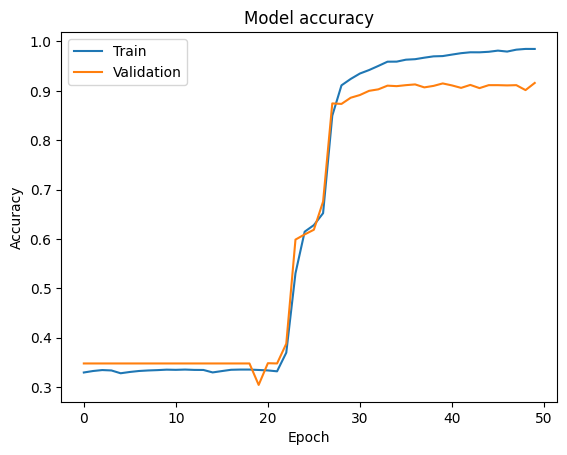

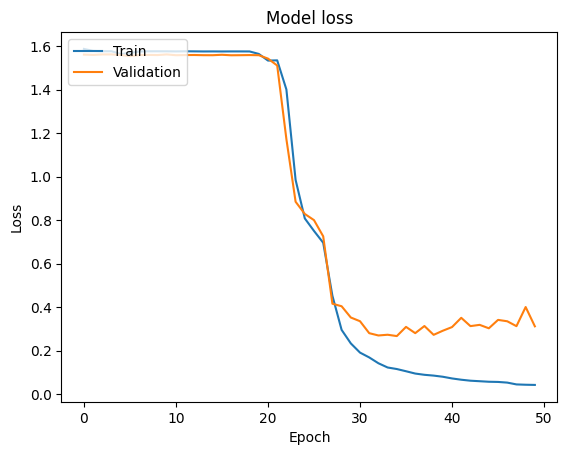

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


63/63 [==============================] - 1s 19ms/step


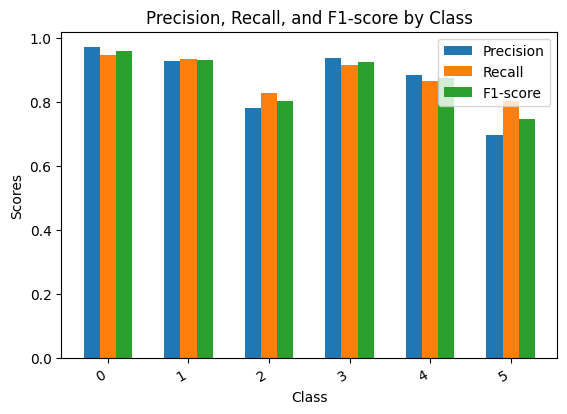

In [ ]:
# Make predictions on the test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure y_test is in categorical label format
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
report = classification_report(y_test_labels, y_pred, output_dict=True)

# Extract precision, recall, and F1-score for each class
precision = [report[str(i)]['precision'] for i in range(len(report) - 3)]  # Exclude support and avg rows
recall = [report[str(i)]['recall'] for i in range(len(report) - 3)]
f1_score = [report[str(i)]['f1-score'] for i in range(len(report) - 3)]

# Class labels
class_labels = [str(i) for i in range(len(report) - 3)]  # Exclude support and avg rows

# Plot precision, recall, and F1-score
x = np.arange(len(class_labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Auto-rotate labels
fig.autofmt_xdate()

plt.show()


In [ ]:
# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

63/63 [==============================] - 2s 26ms/step
Test Accuracy: 0.9160
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       581
           1       0.93      0.94      0.93       695
           2       0.78      0.83      0.80       159
           3       0.94      0.92      0.93       275
           4       0.89      0.87      0.88       224
           5       0.70      0.80      0.75        66

    accuracy                           0.92      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.92      0.92      0.92      2000



<h2>Load the Model</h2>

In [8]:
from google.colab import drive
drive.mount('/content/drive')
LSTM_loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/CENG464 modeller/LSTM/lstm_model_50_epoch.h5")

Mounted at /content/drive


63/63 [==============================] - 2s 18ms/step


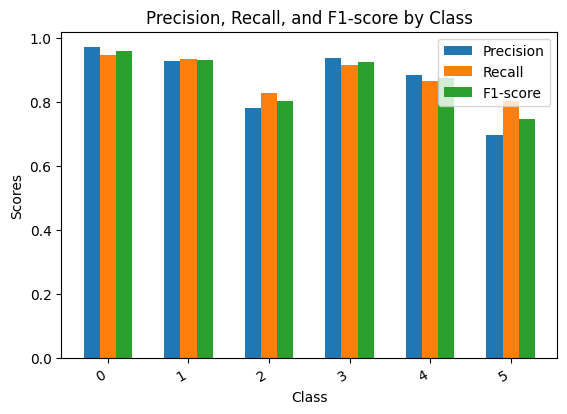

In [9]:
# Make predictions on the test data
y_pred_prob = LSTM_loaded_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure y_test is in categorical label format
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
report = classification_report(y_test_labels, y_pred, output_dict=True)

# Extract precision, recall, and F1-score for each class
precision = [report[str(i)]['precision'] for i in range(len(report) - 3)]  # Exclude support and avg rows
recall = [report[str(i)]['recall'] for i in range(len(report) - 3)]
f1_score = [report[str(i)]['f1-score'] for i in range(len(report) - 3)]

# Class labels
class_labels = [str(i) for i in range(len(report) - 3)]  # Exclude support and avg rows

# Plot precision, recall, and F1-score
x = np.arange(len(class_labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Auto-rotate labels
fig.autofmt_xdate()

plt.show()


In [10]:
# Predict on the test data
y_pred = LSTM_loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

63/63 [==============================] - 3s 51ms/step
Test Accuracy: 0.9160
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       581
           1       0.93      0.94      0.93       695
           2       0.78      0.83      0.80       159
           3       0.94      0.92      0.93       275
           4       0.89      0.87      0.88       224
           5       0.70      0.80      0.75        66

    accuracy                           0.92      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.92      0.92      0.92      2000



63/63 [==============================] - 4s 64ms/step
Class 0 - Best threshold: 0.10119669139385223
Class 1 - Best threshold: 0.807818591594696
Class 2 - Best threshold: 0.3910996913909912
Class 3 - Best threshold: 0.5244221091270447
Class 4 - Best threshold: 0.47141990065574646
Class 5 - Best threshold: 0.31683647632598877


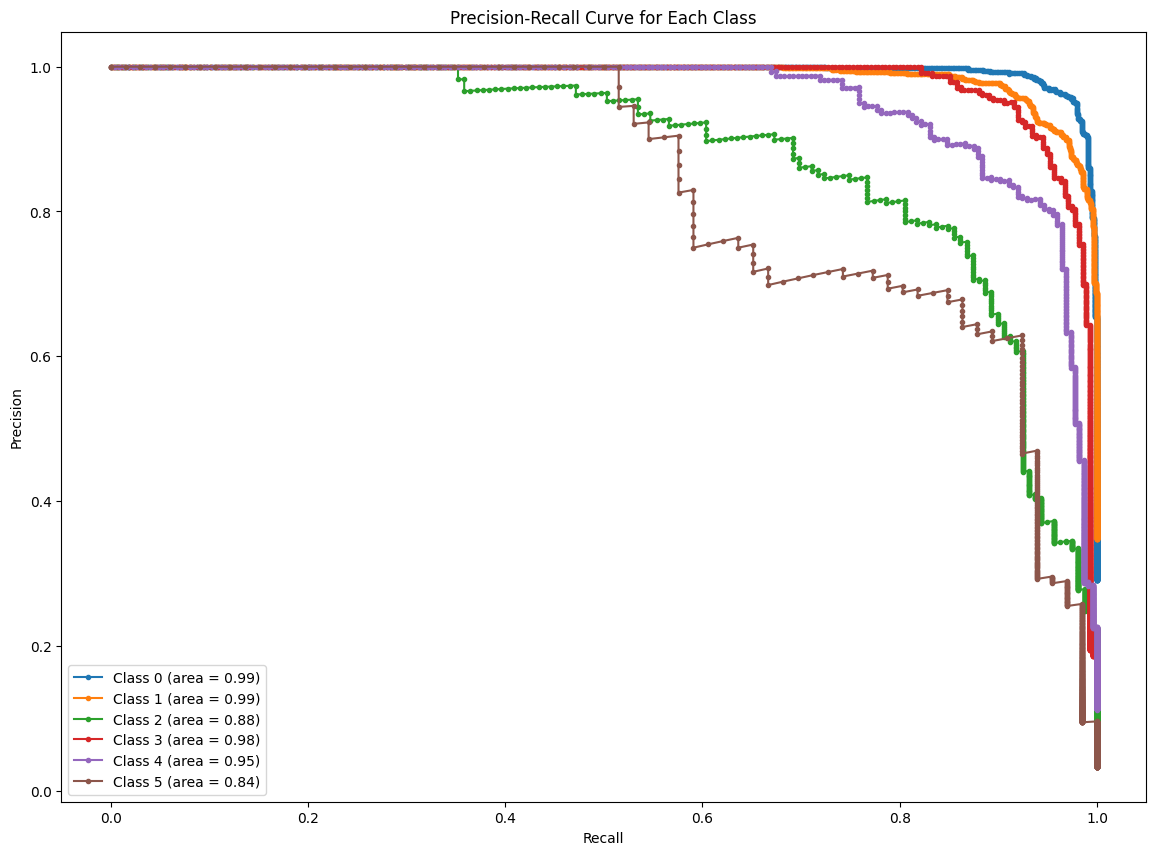

In [14]:
import keras
from keras.models import load_model
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, f1_score, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Make predictions
y_pred_proba = LSTM_loaded_model.predict(X_test)

num_classes = y_pred_proba.shape[1]
y_test_binarized = label_binarize(y_test, classes=[i for i in range(num_classes)])

# Plot precision-recall curve for each class
plt.figure(figsize=(14, 10))

for i in range(num_classes):
    precision, recall, thresholds = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])

    # Optionally, calculate F1 score to find the best threshold
    from sklearn.metrics import f1_score

    f1_scores = [f1_score(y_test_binarized[:, i], (y_pred_proba[:, i] >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Class {i} - Best threshold: {best_threshold}")

    # Plot the precision-recall curve
    plt.plot(recall, precision, marker='.', label=f'Class {i} (area = {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='best')
plt.show()

<h1>BERT TAKE ONE</h1>

In [1]:
from google.colab import drive
import torch
from transformers import BertForSequenceClassification

# Mount Google Drive
drive.mount('/content/drive')

# Instantiate the BERT model
num_labels = 6  # Adjust this according to your specific task
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Load the state dictionary
model.load_state_dict(torch.load('/content/drive/MyDrive/CENG464 modeller/BERTler/01 bert model 4 epoch.pth', map_location=torch.device('cpu')))

# Move the model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
texts = train_df.text.values
labels = train_df.label.values
test_texts = test_df.text.values
test_labels = test_df.label.values

# Didn't encounter any ' symbol but understood it was a suffix-like
print('Original: ', texts[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(texts[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

# Calculate maximum length
max_len = 0
for sent in texts:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

test_max_len = 0
for sent in test_texts:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    test_max_len = max(test_max_len, len(input_ids))

print('Max test sentence length: ', test_max_len)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Original:  i didnt feel humiliated
Tokenized:  ['i', 'didn', '##t', 'feel', 'humiliated']
Token IDs:  [1045, 2134, 2102, 2514, 26608]
Max sentence length:  87
Max test sentence length:  66


In [10]:
# From encoding to dictionary, from dictionary to tensors
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', texts[0])
print('Token IDs:', input_ids[0])
print("Attention masks:", attention_masks[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  i didnt feel humiliated
Token IDs: tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])
Attention masks: tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0

<ipython-input-10-8b7724e78fa6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [12]:
test_input_ids = []
test_attention_masks = []

for t_text in test_texts:
    encoded_dict = tokenizer.encode_plus(
        t_text,
        add_special_tokens=True,
        max_length=test_max_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

print('Original: ', test_texts[0])
print('Token IDs:', test_input_ids[0])
print("Attention_masks:", test_attention_masks[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  im feeling rather rotten so im not very ambitious right now
Token IDs: tensor([  101, 10047,  3110,  2738, 11083,  2061, 10047,  2025,  2200, 12479,
         2157,  2085,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])
Attention_masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


<ipython-input-12-463150c204a6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels)


In [13]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

# Ensure test dataset and dataloader are created correctly
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)


12,800 training samples
3,200 validation samples


In [14]:
# Initialize empty lists for predictions and true labels
predictions = []
true_labels = []

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()

    predictions.extend(list(pred_flat))
    true_labels.extend(list(labels_flat))


In [15]:
# Import classification report from sklearn
from sklearn.metrics import classification_report


# Print classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.96      0.94      0.95       695
           2       0.80      0.84      0.82       159
           3       0.93      0.91      0.92       275
           4       0.86      0.92      0.89       224
           5       0.80      0.65      0.72        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.88      2000
weighted avg       0.93      0.92      0.92      2000



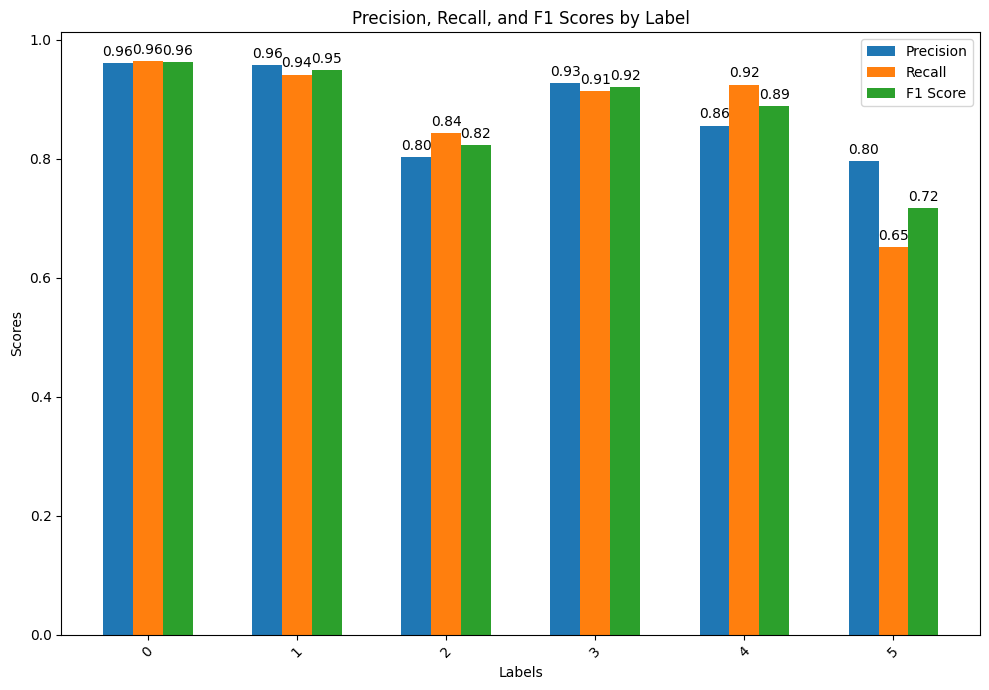

In [24]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
import numpy as np

# Get classification report as dictionary
report = classification_report(true_labels, predictions, output_dict=True)

# Extract metrics for each label
labels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

# Plotting the results
x = np.arange(len(labels))  # Label locations
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 7))

rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Labels')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Scores by Label')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Show plot
plt.show()


In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
def tokenize_data(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

dataset_for_bert = dataset.map(tokenize_data, batched=True)
print(dataset_for_bert)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [ ]:
print(dataset_for_bert["train"])
print(dataset_for_bert["train"][0])

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16000
})
{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mas

In [ ]:
# Prepare the dataset for TensorFlow
def prepare_dataset(data):
    return data['input_ids'], data['attention_mask'], data['label']

train_data, val_data = train_test_split(dataset_for_bert['train'], test_size=0.2)
train_inputs = (train_data['input_ids'], train_data['attention_mask'])
train_labels = tf.keras.utils.to_categorical(train_data['label'], num_classes=6)
val_inputs = (val_data['input_ids'], val_data['attention_mask'])
val_labels = tf.keras.utils.to_categorical(val_data['label'], num_classes=6)
test_inputs = (dataset_for_bert['test']['input_ids'], dataset_for_bert['test']['attention_mask'])
test_labels = tf.keras.utils.to_categorical(dataset_for_bert['test']['label'], num_classes=6)

In [ ]:
print(train_data)
print(train_inputs)
print(train_labels)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(32)

In [ ]:
# Initialize the BERT model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

bert_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bert_model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 109486854 (417.66 MB)
Trainable params: 109486854 (417.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
bert_history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # You can increase the number of epochs if needed
)


Epoch 1/10


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
400/400 [==============================] - 455s 922ms/step - loss: 5.6245 - accuracy: 0.3347 - val_loss: 5.6413 - val_accuracy: 0.3191
Epoch 2/10
400/400 [==============================] - 348s 870ms/step - loss: 5.3920 - accuracy: 0.3391 - val_loss: 5.6413 - val_accuracy: 0.3191
Epoch 3/10
400/400 [==============================] - 346s 866ms/step - loss: 7.9004 - accuracy: 0.3391 - val_loss: 10.4768 - val_accuracy: 0.3191
Epoch 4/10
400/400 [==============================] - 346s 866ms/step - loss: 10.6719 - accuracy: 0.3391 - val_loss: 10.4768 - val_accuracy: 0.3191
Epoch 5/10
400/400 [==============================] - 346s 865ms/step - loss: 10.6719 - accuracy: 0.3391 - val_loss: 10.4768 - val_accuracy: 0.3191
Epoch 6/10
400/400 [==============================] - 346s 866ms/step - loss: 10.6568 - accuracy: 0.3391 - val_loss: 10.4768 - val_accurac

<h1>BERT TAKE TWO</h1>

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from datasets import load_dataset
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("dair-ai/emotion")

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
def tokenize_data(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=64)

dataset = dataset.map(tokenize_data, batched=True)

# Prepare the dataset for TensorFlow
def prepare_dataset(data):
    return data['input_ids'], data['attention_mask'], data['label']

train_data, val_data = train_test_split(dataset['train'], test_size=0.1)
train_inputs = (train_data['input_ids'], train_data['attention_mask'])
train_labels = tf.keras.utils.to_categorical(train_data['label'], num_classes=6)
val_inputs = (val_data['input_ids'], val_data['attention_mask'])
val_labels = tf.keras.utils.to_categorical(val_data['label'], num_classes=6)
test_inputs = (dataset['test']['input_ids'], dataset['test']['attention_mask'])
test_labels = tf.keras.utils.to_categorical(dataset['test']['label'], num_classes=6)

# Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(32)

# Initialize the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4  # You can increase the number of epochs if needed
)

# Evaluate the model
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x78cdf4559a20>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/MyDrive/bert_10_epochs.h5'

bert_model.save(model_save_path)
print(f'Model saved to {model_save_path}')

In [ ]:
classifier = keras_nlp.models.Classifier.from_preset(
    "bert_base_en",
    num_classes=2,
)